# Predicting Stolen Base Attempts and Successes

Author: Enikő Gergely <br>
Date: January 08, 2020


# Introduction
In this notebook I will build a model that can predict the probability of a successful stolen base given that the runner takes off for an empty second base. Once we have the probabilities they can be used to decide whether to attempt a base steal or not. Using the run values we can calculate the percentage when it is a good tactic to steal in that situation and if the predicted probability is higher the runner can go for it or we can expect a steal.

# Importing packages, functions and dataset

In [60]:
## data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# machine learning
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, log_loss, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm #, , datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_selection import RFECV, SelectFromModel,  RFE, SelectKBest, chi2

#import data to pandas dataframe
df_events= pd.read_csv('events.csv')
df_games= pd.read_csv('games.csv')
df_pitcher_times= pd.read_csv('pitcher_times.csv')
df_players= pd.read_csv('players.csv')
df_poptime= pd.read_csv('poptime.csv')
df_sprint_speed= pd.read_csv('sprint_speed.csv')
df_pitcher_hand= pd.read_csv('pitcher_hand.csv') # from same source as poptime and sprint speed (baseballsavant)

#create merged dataset
merged = df_events.merge(df_pitcher_times, how = 'left', left_on = ['pitcher_id'], right_on= ['pitcher'] , suffixes= ('_x', '_pitcher'))
merged = merged.merge(df_poptime, how = 'left', left_on = ['pos2_fld_id'], right_on=  ['player_id'])
merged = merged.merge(df_sprint_speed, how = 'left', left_on = ['base_run1_id'], right_on = ['player_id'])
merged = merged.merge(df_games, how = 'left', on = ['game_id'])
merged = merged.merge(df_pitcher_hand, how = 'left', on = ['pitcher_id'])

In [94]:
# Confusion matrix, normalized confusion matrix used for model evaluation
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(['CS', 'SB'])] 
    classes = classes.index.tolist()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [3]:
merged.describe()

,inning,home_score,away_score,outs,balls,strikes,batter_id,pitcher_id,pos2_fld_id,pos3_fld_id,...,player_id_y,team_id_y,age_y,competitive_runs,hp_to_1b,sprint_speed,home_team_id,visiting_team_id,game_time_temp,announced_attendance
count,61837.000000,61837.000000,61837.000000,61837.000000,61837.000000,61837.000000,61837.000000,61837.000000,61837.000000,61837.000000,...,60766.000000,60766.000000,60766.000000,60766.000000,59703.000000,60766.000000,61837.000000,61837.000000,61837.000000,61837.000000
mean,5.080276,2.464803,2.676132,1.145318,1.185908,1.236978,571224.054013,572902.073031,548154.392775,550366.412148,...,570954.333739,128.624790,28.451124,164.320854,4.400850,27.104565,128.653816,128.900464,73.463477,28220.621812
std,2.700153,2.727064,2.881870,0.787995,1.082448,0.827527,67222.283121,67299.397079,67923.574101,70410.490794,...,67352.212948,14.352251,3.679759,72.064952,0.208716,1.447412,14.292478,14.329045,10.726298,11253.461533
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,400085.000000,282332.000000,425772.000000,405395.000000,...,405395.000000,108.000000,20.000000,5.000000,3.930000,20.800000,108.000000,108.000000,34.000000,0.000000
25%,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,519203.000000,519443.000000,488771.000000,502517.000000,...,519058.000000,115.000000,26.000000,112.000000,4.250000,26.200000,115.000000,115.000000,68.000000,18952.000000
50%,5.000000,2.000000,2.000000,1.000000,1.000000,1.000000,592518.000000,592865.000000,553869.000000,543333.000000,...,592450.000000,133.000000,28.000000,168.000000,4.370000,27.200000,133.000000,134.000000,74.000000,28359.000000
75%,7.000000,4.000000,4.000000,2.000000,2.000000,2.000000,622534.000000,621389.000000,600474.000000,607752.000000,...,622534.000000,141.000000,31.000000,218.000000,4.530000,28.200000,141.000000,141.000000,81.000000,37059.000000
max,19.000000,21.000000,23.000000,2.000000,4.000000,3.000000,676606.000000,677976.000000,669257.000000,670712.000000,...,670712.000000,158.000000,39.000000,324.000000,5.030000,30.800000,158.000000,158.000000,103.000000,59659.000000


In [4]:
merged.head(4)

,game_id,inning,inning_half,home_score,away_score,outs,balls,strikes,batter_id,pitcher_id,...,hp_to_1b,sprint_speed,date,home_team_id,home_team,visiting_team_id,visiting_team,game_time_temp,announced_attendance,pitch_hand
0,2019/03/20/seamlb-oakmlb-1,1,Top,0,0,2,1,0,429665,571666,...,4.37,26.7,2019-03-20,133,Athletics,136,Mariners,72,45787,R
1,2019/03/20/seamlb-oakmlb-1,2,Bottom,1,0,0,0,1,621566,594835,...,4.44,27.0,2019-03-20,133,Athletics,136,Mariners,72,45787,L
2,2019/03/20/seamlb-oakmlb-1,2,Bottom,1,0,0,0,1,621566,594835,...,4.44,27.0,2019-03-20,133,Athletics,136,Mariners,72,45787,L
3,2019/03/20/seamlb-oakmlb-1,2,Bottom,2,0,1,1,0,460026,594835,...,4.36,28.1,2019-03-20,133,Athletics,136,Mariners,72,45787,L


In [5]:
merged.columns.values

array(['game_id', 'inning', 'inning_half', 'home_score', 'away_score',
       'outs', 'balls', 'strikes', 'batter_id', 'pitcher_id',
       'pos2_fld_id', 'pos3_fld_id', 'pos4_fld_id', 'pos5_fld_id',
       'pos6_fld_id', 'pos7_fld_id', 'pos8_fld_id', 'pos9_fld_id',
       'base_run1_id', 'base_run2_id', 'base_run3_id', 'sb_flag',
       'cs_flag', 'pitcher', 'windup_time', 'pitch_time', 'num_pitches',
       'catcher', 'player_id_x', 'team_id_x', 'age_x',
       'maxeff_arm_2b_3b_sba', 'exchange_2b_3b_sba', 'pop_2b_sba_count',
       'pop_2b_sba', 'pop_2b_cs', 'pop_2b_sb', 'pop_3b_sba_count',
       'pop_3b_sba', 'pop_3b_cs', 'pop_3b_sb', 'last_name', ' first_name',
       'player_id_y', 'team_id_y', 'team', 'position', 'age_y',
       'competitive_runs', 'hp_to_1b', 'sprint_speed', 'date',
       'home_team_id', 'home_team', 'visiting_team_id', 'visiting_team',
       'game_time_temp', 'announced_attendance', 'pitch_hand'],
      dtype=object)

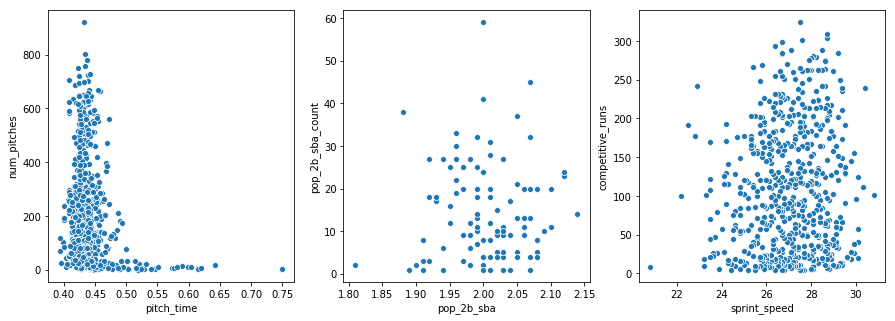

In [8]:
fig, axs = plt.subplots(1, 3, figsize = (15,5))
print(axs)
sns.scatterplot(x="pitch_time", y="num_pitches",  data=df_pitcher_times, ax=axs[0])
sns.scatterplot(x="pop_2b_sba", y="pop_2b_sba_count",  data=df_poptime, ax=axs[1])
sns.scatterplot(x="sprint_speed", y="competitive_runs",  data=df_sprint_speed , ax=axs[2])

There are some pitchers with very high pitch_time and low number of pitches. Catchers and runners data looks better. Just checking some interesting data points: in catchers dataset (1.88, 38) is J.T. Realmuto who has 47% CS% in 2019 while (2.14,14) is Stephen Vogt: 17% CS%. In runners dataset (22.9, 242) is Wilson Ramos who only has 1 SB in 2019. On the other side (30.4, 240) is Trea Turner who has 35 SB and just 5 CS in 2019. Sprint_speed and pop_2b_sba can be good features to predict steal attempt successes. 

# Select relevant data only
I will build a supervised learning algorithm which can predict the outcome (caught steal or stolen base) when there is a steal attempt so I need historical data of steal attempts and their outcomes that I can use later for training and testing the model. I filter the data to 'sb_flag'=1 or 'cs_flag' =1 (all the steal attempts) and for cases when there is runner only on first base. 
Pickoffs should be also excluded from the population. There is no indicator for pickoffs in the data so I assume those are not included.

Total # of rows: 61837
Total # of sba rows: 2893
Total # of sba rows with no runner on 2nd 2633
Total # of sba rows with no other runners: 2208
Number of CS:  686
Number of SB:  1522


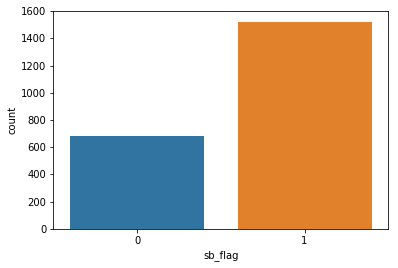

In [9]:
# only SB and CS
print("Total # of rows:" , len(merged))
df_sba = merged [merged['sb_flag'] + merged['cs_flag'] == 1]
print("Total # of sba rows:" ,len(df_sba))

#only cases when runner on 1B only
df_sba = df_sba [df_sba['base_run2_id'].isnull() == True]
print("Total # of sba rows with no runner on 2nd" ,len(df_sba))
df_sba = df_sba [df_sba['base_run3_id'].isnull() == True]
print("Total # of sba rows with no other runners:" ,len(df_sba))

#show number of CS (sb_flag = 0) and SB (sb_flag = 1)
ax=sns.countplot(df_sba["sb_flag"], label="Count")
SB, CS = df_sba["sb_flag"].value_counts()
print('Number of CS: ', CS)
print('Number of SB: ', SB)

# Missing values
As a first step I remove the columns which won't be part of the analysis later like player information (id, names, position, age, team id and names), date, attendance, game time, and some data from poptime which are not relevant and windup time (windup is used when there are no runners on base or only on third).

There are not too many missing values so I could just remove those lines from the dataset. I don't expect maxeff_arm_2b_3b_sba and hp_to_1b to be included in the final model so only 7 rows would be removed.

I decided to impute values for the missing ones:
- sprint_speed: these are all pitchers since they are not included in the sprint_speed dataset. I will impute the mean value of DH, 1B and C for the sprint_speed since they are the three slowest categories. 
- competitive run: I use the mean of DHs.
- pop_2b_sba, pop_2b_sba_count: There are two catchers missing who had probably no throws on stolen base attempts in 2019. I will impute mean value for pop_2b_sba and add "1" as pop_2b_sba_count.
- exchange_2b_3b_sba, maxeff_arm_2b_3b_sba, hp_to_1b: probably won't be used in later analysis, I will just use the mean values.


In [10]:
#selecting features which won't be added to the models at any stage of the analysis
not_used_features = ['game_id',  'inning_half', 'batter_id', 'pitcher_id',
       'pos2_fld_id', 'pos3_fld_id', 'pos4_fld_id', 'pos5_fld_id',
       'pos6_fld_id', 'pos7_fld_id', 'pos8_fld_id', 'pos9_fld_id','base_run1_id', 'base_run2_id', 'base_run3_id', 'pitcher', 'catcher', 'player_id_x', 'team_id_x', 'age_x',
        'pop_2b_cs', 'pop_2b_sb', 'pop_3b_sba_count', 'pop_3b_sba', 'pop_3b_cs', 'pop_3b_sb', 'last_name', ' first_name', 'player_id_y', 'team_id_y', 'team', 'position', 'age_y',
        'date', 'home_team_id', 'home_team', 'visiting_team_id', 'visiting_team', 'game_time_temp', 'announced_attendance', 'windup_time']


features_initial = list(df_sba.drop(df_sba[not_used_features], axis = 1).columns)

# Number of missing values in each column of features list that might be used for modeling
missing_val_count_by_column = (df_sba[features_initial].isna().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

maxeff_arm_2b_3b_sba    28
exchange_2b_3b_sba       2
pop_2b_sba_count         2
pop_2b_sba               2
competitive_runs         5
hp_to_1b                52
sprint_speed             5
dtype: int64


In [11]:
df_sba[df_sba['sprint_speed'].isnull()][['base_run1_id', 'last_name', 'sb_flag', 'competitive_runs']]

,base_run1_id,last_name,sb_flag,competitive_runs
12004,656427,NaN,1,NaN
33683,453286,NaN,1,NaN
50305,615698,NaN,0,NaN
52680,425844,NaN,0,NaN
54635,453286,NaN,1,NaN


They are all pitchers: 
 -  656427	Jack Flaherty, 
 - 453286	Max Scherzer,
 - 615698	Carl Quantrill,
 - 425844	Zack Greinke

In [12]:
df_sba[df_sba['pop_2b_sba'].isnull()][['pos2_fld_id', 'sb_flag', 'exchange_2b_3b_sba','pop_2b_sba_count', 'pop_2b_sba']]

,pos2_fld_id,sb_flag,exchange_2b_3b_sba,pop_2b_sba_count,pop_2b_sba
38078,492802,1,NaN,NaN,NaN
53758,543592,1,NaN,NaN,NaN


Catchers: 
- 492802 Juan Graterol, 
- 543592 Austin Nola

In [13]:
df_sprint_speed.groupby(['position'])['sprint_speed', 'hp_to_1b', "competitive_runs"].mean().sort_values(by='sprint_speed', ascending=False)

,sprint_speed,hp_to_1b,competitive_runs
position,,,
CF,28.555696,4.224143,105.949367
SS,27.784746,4.292353,143.406780
LF,27.562651,4.352609,99.012048
RF,27.560000,4.364231,119.500000
2B,27.267073,4.327857,109.914634
3B,26.701695,4.468519,128.322034
DH,25.947826,4.561875,96.739130
1B,25.928814,4.569630,121.711864
C,25.490625,4.642432,72.281250


C:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


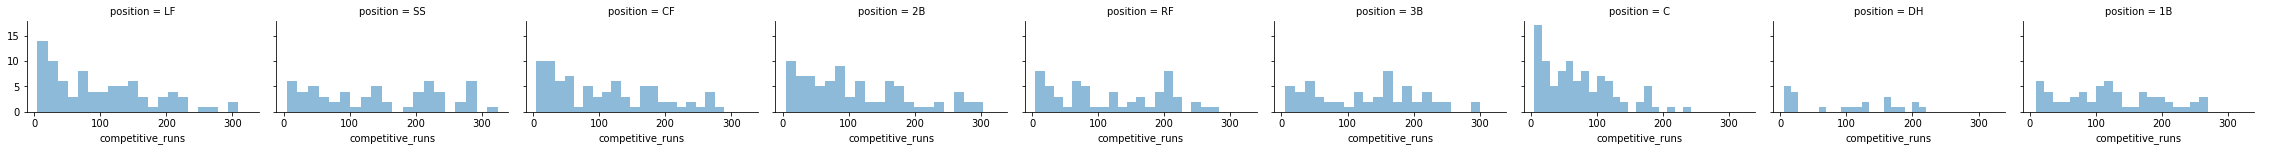

In [16]:
#Competitive runs - distribution by position
grid = sns.FacetGrid(df_sprint_speed, col='position', size=2.2, aspect=1.6)
grid.map(plt.hist, 'competitive_runs', alpha=.5, bins=20)
grid.add_legend()

In [19]:
# fill na for sprint_speed
c_1b_dh_sprint_speed = df_sprint_speed[(df_sprint_speed['position'] == "1B" ) | (df_sprint_speed['position'] == "DH") | (df_sprint_speed['position'] == "C")]['sprint_speed'].mean()
df_sba['sprint_speed'] = df_sba['sprint_speed'].fillna(c_1b_dh_sprint_speed)
print ("imputed value:", c_1b_dh_sprint_speed)

# fill na for competitive runs
dh_competitive_runs = df_sprint_speed[(df_sprint_speed['position'] == "DH" )]['competitive_runs'].mean()
df_sba['competitive_runs'] = df_sba['competitive_runs'].fillna(dh_competitive_runs)
print("imputed for competitive_runs:", dh_competitive_runs)

# fill na for hp_to_1b
hp_to_1b_mean = df_sprint_speed['hp_to_1b'].mean()
df_sba['hp_to_1b'] = df_sba['hp_to_1b'].fillna(hp_to_1b_mean) 
print("imputed for hp_to_1b:", hp_to_1b_mean)

#fill na for exchange_2b_3b_sba, pop_2b_sba, pop_2b_sba_count, maxeff_arm_2b_3b_sba
exchange_2b_3b_sba_mean = df_poptime['exchange_2b_3b_sba'].mean()
pop_2b_sba_mean = df_poptime['pop_2b_sba'].mean()
maxeff_arm_2b_3b_sba_mean = df_poptime['maxeff_arm_2b_3b_sba'].mean() 

df_sba['exchange_2b_3b_sba'] = df_sba['exchange_2b_3b_sba'].fillna(exchange_2b_3b_sba_mean)
df_sba['pop_2b_sba'] = df_sba['pop_2b_sba'].fillna(pop_2b_sba_mean)
df_sba['pop_2b_sba_count'] = df_sba['pop_2b_sba_count'].fillna(1) # add 1 to not to have much impact on data
df_sba['maxeff_arm_2b_3b_sba'] = df_sba['maxeff_arm_2b_3b_sba'].fillna(maxeff_arm_2b_3b_sba_mean) # will not be used

print("imputed for exchange_2b_3b_sba:", exchange_2b_3b_sba_mean)
print("imputed for pop_2b_sba:",pop_2b_sba_mean)
print("imputed for maxeff_arm_2b_3b_sba:", maxeff_arm_2b_3b_sba_mean)

imputed value: 25.694943820224722
imputed for competitive_runs: 96.73913043478261
imputed for hp_to_1b: 4.410607843137251
imputed for exchange_2b_3b_sba: 0.7266666666666667
imputed for pop_2b_sba: 2.00421568627451
imputed for maxeff_arm_2b_3b_sba: 81.27395833333335


In [20]:
# Check if there is no missing values left
missing_val_count_by_column = (df_sba.drop(df_sba[not_used_features], axis = 1).isna().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


# Visualizations (continuous features)
I will use seaborn plots to visualize continuous features that will help to select relevant features. I create boxplots and violinplot to see if distributions are different for steals and caught steals. Swarmplots show the separation between CS and SB for all features. Before creating the plots I use standardization (differences between values of features are very high to observe on one plot otherwise).

In [21]:
#select continuous features
features_initial_cont = ['pitch_time', 'num_pitches', 'maxeff_arm_2b_3b_sba', 'exchange_2b_3b_sba', 
                         'pop_2b_sba_count', 'pop_2b_sba',  'competitive_runs', 'hp_to_1b', 'sprint_speed']

# rest are categorical
features_initial_categ = list(df_sba[features_initial].drop(df_sba[features_initial_cont], axis = 1).columns)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

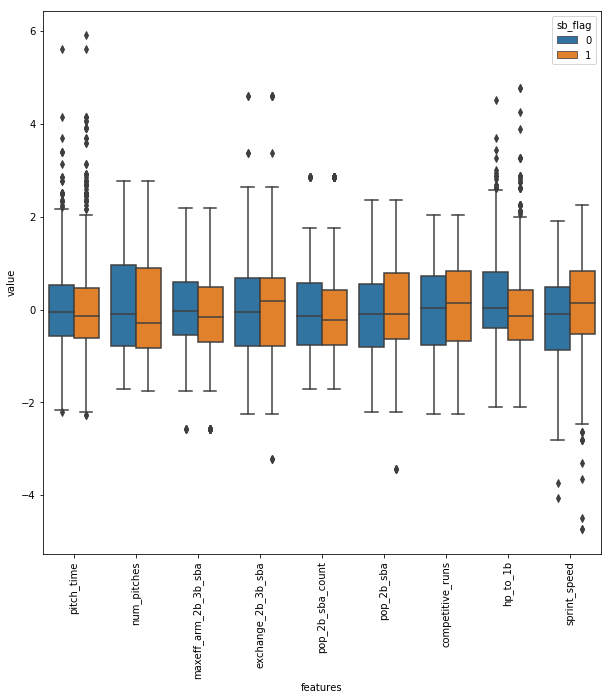

In [22]:
#boxplot 

data = df_sba[features_initial_cont]
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([df_sba.sb_flag , data_n_2],axis=1)
data = pd.melt(data,id_vars="sb_flag",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="sb_flag", data=data)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

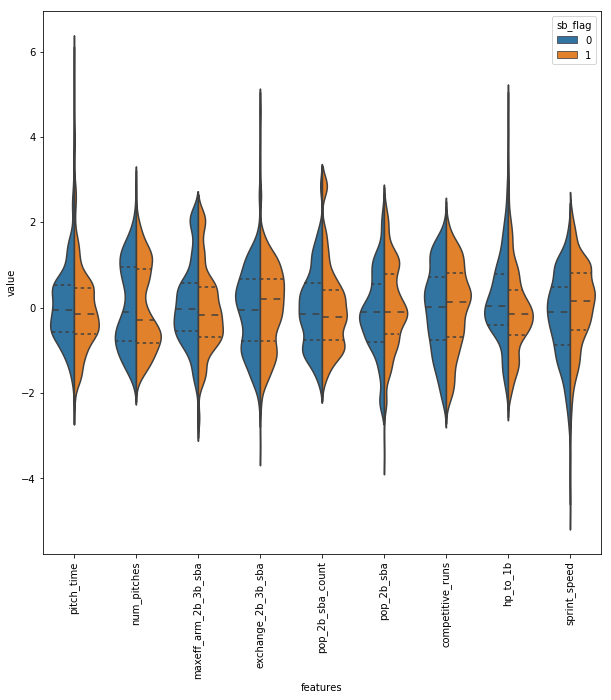

In [23]:
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="sb_flag", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

Boxplots are good to see outliers and see if a feature can be good for classification (median of CS and SB are separated).
For example, sprint_speed might be good since median of the CS and SB looks like separated, however pop_2b_sba_count does not look like separated which means it doesn't have good information for classification. 

hp_to_1b and sprint_speed looks very similar as expected just with negative correlation. I will check correlation between them and also catcher poptime features (maxeff_arm_2b_3b_sba, exchange_2b_3b_sba, pop_2b_sba) since pop_2b_sba is a combination of the other two based on baseball savant. If they are correlated we can keep only one.

              hp_to_1b  sprint_speed
hp_to_1b      1.000000     -0.795973
sprint_speed -0.795973      1.000000


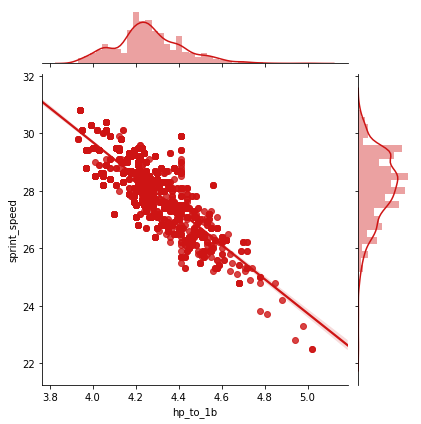

In [24]:
# hp_to_1b and sprint_speed
print(df_sba[['hp_to_1b', 'sprint_speed']].corr())
sns.jointplot(df_sba.loc[:, 'hp_to_1b'], df_sba.loc[:, 'sprint_speed'], kind="regg", color="#ce1414")

                      pop_2b_sba  exchange_2b_3b_sba  maxeff_arm_2b_3b_sba
pop_2b_sba              1.000000            0.462386             -0.726329
exchange_2b_3b_sba      0.462386            1.000000              0.074110
maxeff_arm_2b_3b_sba   -0.726329            0.074110              1.000000


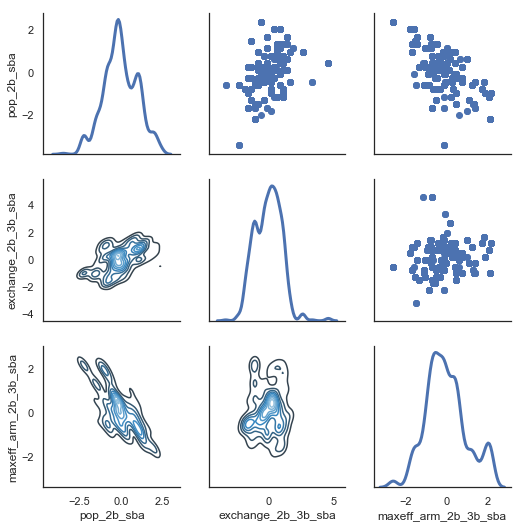

In [25]:
print(df_sba[['pop_2b_sba', 'exchange_2b_3b_sba', 'maxeff_arm_2b_3b_sba']].corr())
sns.set(style = "white")
df = data_n_2[['pop_2b_sba', 'exchange_2b_3b_sba', 'maxeff_arm_2b_3b_sba']].dropna(how = "any")
g = sns.PairGrid(df, diag_sharey= False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

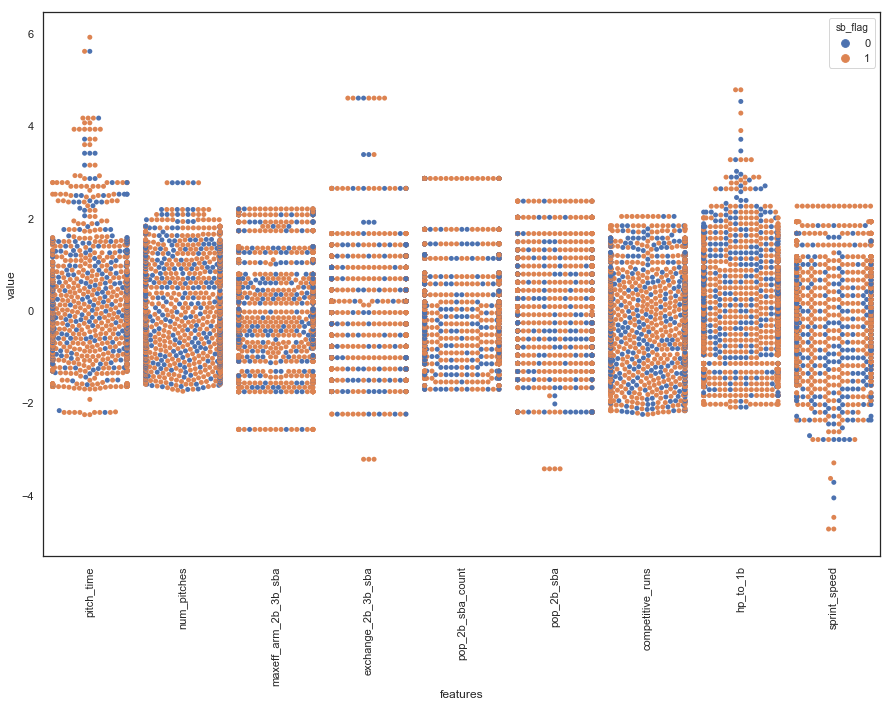

In [20]:
#swarmplot
plt.figure(figsize=(15, 10))
sns.swarmplot(x="features", y = "value", hue = "sb_flag", data =data)

plt.xticks(rotation=90)

Looking at the above swarmplots none of the features really shows a good separation between SB and CS so we might need new features for classification.

Finally I check the correlations for the above features.

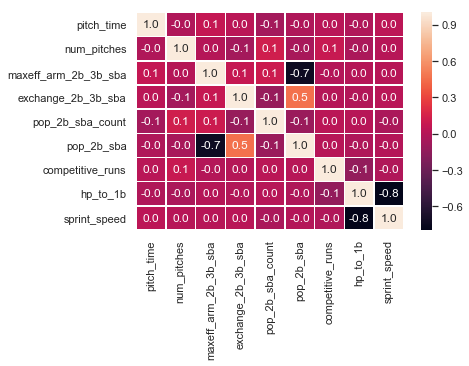

In [26]:
plt.figure(1)
corr = df_sba[features_initial_cont].corr()
sns.heatmap(corr, annot= True, linewidth = .5, fmt = '.1f')

As 'sprint_speed' and 'hp_to_1b' are correlated to each other I will keep 'sprint_speed' only. 'maxeff_arm_2b_3b_sba', 'exchange_2b_3b_sba' are both correlated to 'pop_2b_sba' so I will only keep 'pop_2b_sba' which is some combination of the other two.

In [27]:
# remove correlated features from features_list
for feature in ['hp_to_1b', 'maxeff_arm_2b_3b_sba','exchange_2b_3b_sba']: 
    features_initial.remove(feature)

# Categorical features (inning, outs, balls, strikes, away/home score)
I will make some transformation on categorical features and create some new features.

In [28]:
features_initial_categ

['inning',
 'home_score',
 'away_score',
 'outs',
 'balls',
 'strikes',
 'sb_flag',
 'cs_flag',
 'pitch_hand']

In [29]:
#create new feature from away_score and home_score to show defensive_lead
df_sba['lead_by_defense'] = np.where(df_sba.home_team_id == df_sba.team_id_y, df_sba.away_score - df_sba.home_score, df_sba.home_score - df_sba.away_score)

#create is_left_handed feature from pitch_hand
df_sba['is_left_handed'] = np.where(df_sba.pitch_hand == "L", 1, 0)

#drop home_score, away_score and pitch_hand from features_initial
for feature in ['home_score','away_score', 'pitch_hand']: 
    features_initial.remove(feature)

#### Balls, Strikes, Outs
Here I will use mean encoding which uses the target variable to generate the new encoded feature: for each unique value in the categorical feature we add the ratio of occurrence of the positive class in the target variable which is the SB success rate. Steps are: select categorical variable, group by the categorical variable and calculate aggregated sum and count of target variable, divide sum by count (which is basically its mean) and join it back to dataset.

        sb_flag      cs_flag      
           mean  sum     sum count
balls                             
0      0.727974  661     247   908
1      0.699725  508     218   726
2      0.724796  266     101   367
3      0.420290   87     120   207
          sb_flag      cs_flag      
             mean  sum     sum count
strikes                             
0        0.734848  582     210   792
1        0.702381  472     200   672
2        0.629032  468     276   744
       sb_flag      cs_flag      
          mean  sum     sum count
outs                             
0     0.674632  367     177   544
1     0.644526  524     289   813
2     0.741481  631     220   851


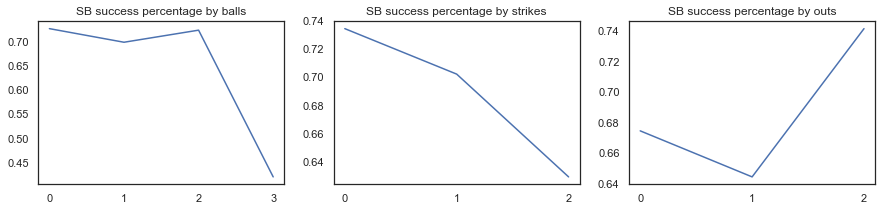

In [43]:
fig, ax = plt.subplots(1,3, figsize = (15,3) )
#balls
mean_encode = df_sba.groupby('balls')['sb_flag', 'cs_flag'].agg({'sb_flag': ['mean', 'sum'], 'cs_flag': ['sum', 'count']})
print(pd.DataFrame(mean_encode))
mean_encode = pd.DataFrame(mean_encode)['sb_flag']['mean']
df_sba['balls_mean_enc'] = df_sba['balls'].map(mean_encode)

ax[0].plot(mean_encode)
ax[0].set_xticks(list(mean_encode.index))
ax[0].title.set_text("SB success percentage by balls")

#strikes
mean_encode = df_sba.groupby('strikes')['sb_flag', 'cs_flag'].agg({'sb_flag': ['mean', 'sum'], 'cs_flag': ['sum', 'count']})
print(pd.DataFrame(mean_encode))
mean_encode = pd.DataFrame(mean_encode)['sb_flag']['mean']
df_sba['strikes_mean_enc'] = df_sba['strikes'].map(mean_encode)

ax[1].plot(mean_encode)
ax[1].set_xticks(  list(mean_encode.index))
ax[1].title.set_text("SB success percentage by strikes")

#outs
mean_encode = df_sba.groupby('outs')['sb_flag', 'cs_flag'].agg({'sb_flag': ['mean', 'sum'], 'cs_flag': ['sum', 'count']})
print(pd.DataFrame(mean_encode))
mean_encode = pd.DataFrame(mean_encode)['sb_flag']['mean']
df_sba['outs_mean_enc'] = df_sba['outs'].map(mean_encode)

ax[2].plot(mean_encode)
ax[2].set_xticks(list(mean_encode.index))
ax[2].title.set_text("SB success percentage by outs")

### Inning
There are some steal attempts in innings later than the 9th that I will regroup and put all 9+ innings into 9th to handle small data issue (some innings have 0 or 100% success rates otherwise). Then I use the same mean encoding technique as earlier.

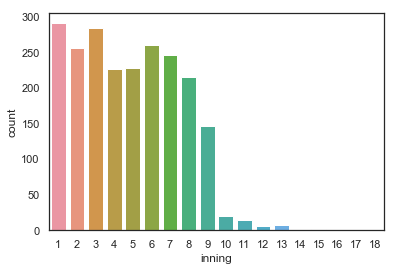

In [44]:
sns.countplot(df_sba["inning"], label="Count")

Text(0.5, 1.0, 'SB success percentage by inning state')

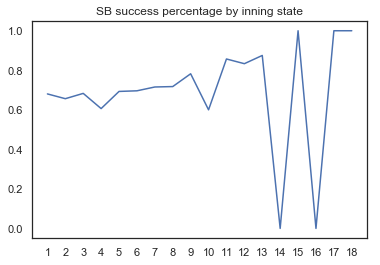

In [45]:
mean_encode = df_sba.groupby('inning')['sb_flag'].mean()
plt.plot(mean_encode)
plt.xticks(list(mean_encode.index))
plt.title("SB success percentage by inning state")


             sb_flag      cs_flag      
                mean  sum     sum count
inning_new                             
1           0.680412  198      93   291
2           0.656250  168      88   256
3           0.683099  194      90   284
4           0.606195  137      89   226
5           0.692982  158      70   228
6           0.696154  181      79   260
7           0.715447  176      70   246
8           0.717593  155      61   216
9           0.771144  155      46   201


Text(0.5, 1.0, 'SB success percentage by inning state')

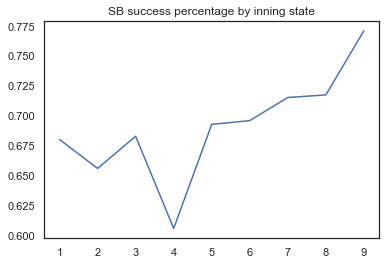

In [46]:
df_sba['inning_new'] = np.where(df_sba.inning >= 9, 9, df_sba.inning)
mean_encode = df_sba.groupby('inning_new')['sb_flag', 'cs_flag'].agg({'sb_flag': ['mean', 'sum'], 'cs_flag': ['sum', 'count']})
print(mean_encode)
mean_encode = pd.DataFrame(mean_encode)['sb_flag']['mean']
df_sba.loc[:, 'inning_mean_enc'] = df_sba['inning_new'].map(mean_encode)

plt.plot(mean_encode)
plt.xticks(list(mean_encode.index))
plt.title("SB success percentage by inning state")


#### Score / lead_by_defense
Same as for innings: I group the 5 and 5+ leads together and use mean encoding.

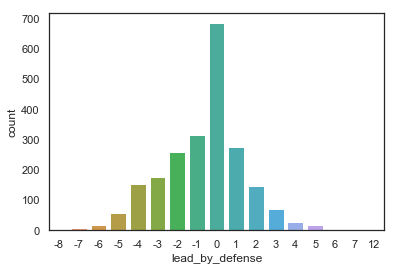

In [47]:
sns.countplot(df_sba["lead_by_defense"], label="Count")

Text(0.5, 1.0, 'SB success percentage by inning state')

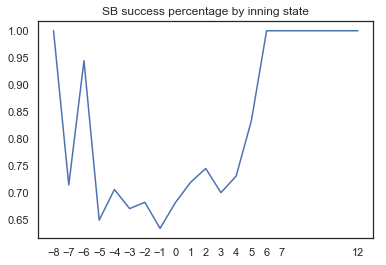

In [48]:
mean_encode = df_sba.groupby('lead_by_defense')['sb_flag'].mean()
plt.plot(mean_encode)
plt.xticks(list(mean_encode.index))
plt.title("SB success percentage by inning state")

                      sb_flag      cs_flag      
                         mean  sum     sum count
lead_by_defense_new                             
-5                   0.722892   60      23    83
-4                   0.705882  108      45   153
-3                   0.670455  118      58   176
-2                   0.682171  176      82   258
-1                   0.633758  199     115   314
 0                   0.681287  466     218   684
 1                   0.718978  197      77   274
 2                   0.744828  108      37   145
 3                   0.700000   49      21    70
 4                   0.730769   19       7    26
 5                   0.880000   22       3    25


Text(0.5, 1.0, 'SB success percentage by lead by defense state')

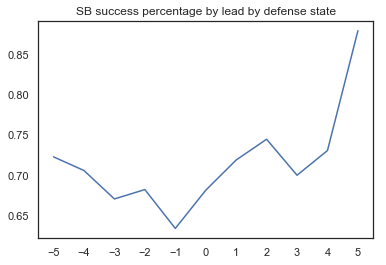

In [49]:
df_sba['lead_by_defense_new'] = np.where(df_sba.lead_by_defense >= 5, 5, 
                                         np.where(df_sba.lead_by_defense <= -5, -5, df_sba.lead_by_defense))
mean_encode = df_sba.groupby('lead_by_defense_new')['sb_flag', 'cs_flag'].agg({'sb_flag': ['mean', 'sum'], 'cs_flag': ['sum', 'count']})
print(mean_encode)
mean_encode = pd.DataFrame(mean_encode)['sb_flag']['mean']
df_sba.loc[:, 'lead_by_defense_mean_enc'] = df_sba['lead_by_defense_new'].map(mean_encode)

plt.plot(mean_encode)
plt.xticks(list(mean_encode.index))
plt.title("SB success percentage by lead by defense state")


In [50]:
#update features list
features_categorical_new =  ['outs_mean_enc', 'balls_mean_enc', 'strikes_mean_enc', 'inning_mean_enc','lead_by_defense_mean_enc', 'is_left_handed'] 
features_initial = features_initial + features_categorical_new

for feature in ['outs', 'balls', 'strikes', 'inning']: # 'lead_by_defense is not in list 
    features_initial.remove(feature)
    
#features_initial

#### Game states - when they steal
I created some tables to see when the steals are most successful and when steal attempts happen.

In [51]:
#score 
mean_encode = df_sba.groupby(['balls', 'strikes'])['sb_flag', 'cs_flag'].sum()
mean_encode['total'] = mean_encode['sb_flag'] + mean_encode['cs_flag']
mean_encode['sb_success'] = mean_encode['sb_flag'] / mean_encode['total']

mean_encode.sort_values(by = 'sb_success', ascending = False)

sb_flag  cs_flag  total  sb_success
balls strikes                                     
3     0              3        0      3    1.000000
      1             19        5     24    0.791667
2     2            128       42    170    0.752941
      0             54       18     72    0.750000
0     1            212       76    288    0.736111
      0            336      121    457    0.735230
1     0            189       71    260    0.726923
      2            162       69    231    0.701299
0     2            113       50    163    0.693252
2     1             84       41    125    0.672000
1     1            157       78    235    0.668085
3     2             65      115    180    0.361111

Success rate on 3-2 count is very low but there are still many attempts. On 3-2 if the pitch is a ball, the hitter will walk and runner advances, if it is a strike hitter is out and the steal attempt can happen (with less than 2 outs). It is always on a strike which might have an impact on the success rate. Since most steals happen on 0-0 count first strike percentage might be a good feature to add.

In [52]:
#outs - balls- strikes states by total number of attempts
mean_encode = df_sba.groupby([ 'outs', 'balls', 'strikes'])['sb_flag', 'cs_flag'].sum()
mean_encode['total'] = mean_encode['sb_flag'] + mean_encode['cs_flag']
mean_encode['sb_success'] = mean_encode['sb_flag'] / mean_encode['total']

mean_encode.sort_values(by = 'total', ascending = False)

sb_flag  cs_flag  total  sb_success
outs balls strikes                                     
2    0     0            147       48    195    0.753846
1    0     0            120       45    165    0.727273
2    0     1             95       38    133    0.714286
     1     2             84       29    113    0.743363
1    3     2             37       70    107    0.345794
2    1     0             80       21    101    0.792079
1    0     1             72       27     99    0.727273
0    0     0             69       28     97    0.711340
1    1     1             62       28     90    0.688889
2    1     1             60       24     84    0.714286
0    1     0             55       27     82    0.670732
1    1     0             54       23     77    0.701299
2    0     2             55       21     76    0.723684
     2     2             55       19     74    0.743243
0    3     2             28       44     72    0.388889
1    1     2             43       27     70    0.614286
     2     1             38       24     62    0.612903
0    1     1             35       26     61    0.573770
     0     1             45       11     56    0.803571
1    2     2             40       16     56    0.714286
     0     2             29       20     49    0.591837
0    1     2             35       13     48    0.729167
     2     2             33        7     40    0.825000
     0     2             29        9     38    0.763158
2    2     1             23       11     34    0.676471
           0             26        7     33    0.787879
0    2     1             23        6     29    0.793103
1    2     0             19        6     25    0.760000
0    2     0              9        5     14    0.642857
1    3     1              9        3     12    0.750000
0    3     1              5        1      6    0.833333
2    3     1              5        1      6    0.833333
1    3     0              1        0      1    1.000000
0    3     0              1        0      1    1.000000
2    3     0              1        0      1    1.000000
           2              0        1      1    0.000000

Most steals happen on 0-0 count with 2 or 1 outs. 2 outs 0-1 and 1-2 counts are also popular to steal. Interesting that with 1 out on 3-2 count there are many steals although the success rate is very low (35%).

In [53]:
#inning - outs - balls- strikes states by total number of attempts
mean_encode = df_sba.groupby(['inning', 'outs', 'balls', 'strikes'])['sb_flag', 'cs_flag'].sum()
mean_encode['total'] = mean_encode['sb_flag'] + mean_encode['cs_flag']
mean_encode['sb_success'] = mean_encode['sb_flag'] / mean_encode['total']

mean_encode.sort_values(by = 'total', ascending = False)

sb_flag  cs_flag  total  sb_success
inning outs balls strikes                                     
3      2    0     0             24        8     32    0.750000
8      2    0     0             26        5     31    0.838710
5      2    0     0             19        4     23    0.826087
7      1    0     0             16        7     23    0.695652
4      1    0     0             14        7     21    0.666667
3      2    0     1             13        8     21    0.619048
7      2    0     0             15        6     21    0.714286
1      1    0     0             17        4     21    0.809524
            3     2              5       16     21    0.238095
2      2    0     1             16        4     20    0.800000
1      2    0     0             16        4     20    0.800000
3      0    0     0             13        6     19    0.684211
2      1    0     0             11        8     19    0.578947
3      1    1     1             13        6     19    0.684211
4      2    0     0             12        7     19    0.631579
6      2    0     1             15        4     19    0.789474
3      1    0     0             14        4     18    0.777778
7      2    1     2             11        7     18    0.611111
1      0    0     0             15        3     18    0.833333
2      2    1     0             15        2     17    0.882353
            0     0             15        1     16    0.937500
6      1    0     0             13        3     16    0.812500
       2    0     0             10        6     16    0.625000
8      1    0     0             13        3     16    0.812500
5      1    0     0             10        5     15    0.666667
4      1    3     2              5       10     15    0.333333
6      2    1     0             13        1     14    0.928571
2      1    3     2              4       10     14    0.285714
1      0    0     1             11        2     13    0.846154
4      2    1     2             10        3     13    0.769231
...                            ...      ...    ...         ...
1      2    3     2              0        1      1    0.000000
8      0    0     2              1        0      1    1.000000
7      2    3     1              0        1      1    0.000000
8      1    3     1              0        1      1    0.000000
2      0    2     1              1        0      1    1.000000
7      1    3     1              0        1      1    0.000000
2      1    2     0              1        0      1    1.000000
8      2    3     1              1        0      1    1.000000
9      0    1     1              0        1      1    0.000000
6      0    1     2              1        0      1    1.000000
9      0    2     2              1        0      1    1.000000
            3     1              1        0      1    1.000000
3      0    3     1              1        0      1    1.000000
       1    3     1              1        0      1    1.000000
10     1    2     0              1        0      1    1.000000
5      1    3     1              1        0      1    1.000000
9      1    2     0              1        0      1    1.000000
5      0    2     1              1        0      1    1.000000
9      1    3     0              1        0      1    1.000000
                  1              1        0      1    1.000000
3      2    2     0              1        0      1    1.000000
4      2    2     0              1        0      1    1.000000
8      0    2     1              1        0      1    1.000000
4      0    0     1              1        0      1    1.000000
9      2    3     0              1        0      1    1.000000
10     0    0     1              1        0      1    1.000000
            3     2              0        1      1    0.000000
       1    1     0              1        0      1    1.000000
                  2              1        0      1    1.000000
18     2    0     0              1        0      1    1.000000

[315 rows x 4 columns]

Adding the innings to the table, the 0-0 counts are still on top with 1 or 2 outs. most of the times it is in 3rd or 8th inning with higher success rate in 8th inning. The difference between 0-0 and 3-2 count in 1st inning with 1 out is interesting here as well (81% vs. 24% while number of attempts are the same).

# Adding new features - Historical values
I will add historical stolen base success rates against the pitchers, catchers and for runners. 
To handle the issue of small sample sizes I will use regression to the mean technique (a player’s true ability is some mixture of his observed performance and the average performance of some smartly selected population to which that player belongs). I will simply use the average of all players in the calculation although there must be a more sophisticated way to regress them to their true talent using similar players' data (for example players with similar amount of steal attempts). 
The players with more data will be closer to observed performance while players with a few data will end up with values pretty close to the population's success rate.

In [61]:
# Calculate success percentages (SB/SBA). Create table including ID | SB | CS | SBA(SB+CS) | success percentage (SB/SBA)
# for catchers, pitchers, runners separately

catchers = df_sba.groupby(['pos2_fld_id'], as_index=False)[['sb_flag', 'cs_flag']].sum() 
catchers['catcher_sba'] = catchers['sb_flag'] + catchers['cs_flag']
catchers['catcher_percentage'] = catchers['sb_flag'] / (catchers['sb_flag'] + catchers['cs_flag'])

pitchers = df_sba.groupby(['pitcher_id'], as_index=False)[['sb_flag', 'cs_flag']].sum() 
pitchers['pitcher_sba'] = pitchers['sb_flag'] + pitchers['cs_flag']
pitchers['pitcher_percentage'] = pitchers['sb_flag'] / (pitchers['sb_flag'] + pitchers['cs_flag'])

runners = df_sba.groupby(['base_run1_id'], as_index=False)[['sb_flag', 'cs_flag']].sum() 
runners['runner_sba'] = runners['sb_flag'] + runners['cs_flag']
runners['runner_percentage'] = runners['sb_flag'] / (runners['sb_flag'] + runners['cs_flag'])



# Regression to the mean
# =====================================
#calculate the mean success percentage and add x mean values to the individual percentages
mean_success_rate = df_sba['sb_flag'].sum() / df_sba['sb_flag'].count()

#Runners
number_of_total = 20
runners['runner_percentage_rtm'] = np.where( runners['runner_sba']> number_of_total, runners['runner_percentage'] , (runners['sb_flag'] + (number_of_total - runners['runner_sba'])*mean_success_rate )/ number_of_total)

#Pitchers
number_of_total = 20
pitchers['pitcher_percentage_rtm'] = np.where( pitchers['pitcher_sba']> number_of_total, pitchers['pitcher_percentage'] ,(pitchers['sb_flag'] + (number_of_total - pitchers['pitcher_sba'])*mean_success_rate )/ number_of_total)

#Catcher
number_of_total = 20
catchers['catcher_percentage_rtm'] = np.where( catchers['catcher_sba']> number_of_total, catchers['catcher_percentage'] ,(catchers['sb_flag'] + (number_of_total - catchers['catcher_sba'])*mean_success_rate )/ number_of_total)


Mean SB%:  0.6893115942028986

mean runner SB% before RTM: 60.18
mean pitcher SB% before RTM: 65.49
mean catcher SB% before RTM: 67.02

mean runner SB% after RTM: 68.78
mean pitcher SB% after RTM: 68.9
mean catcher SB% after RTM: 68.97


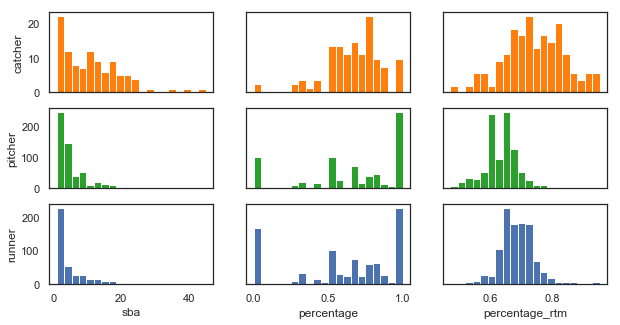

In [58]:
print("Mean SB%: ", mean_success_rate)
print()
print("mean runner SB% before RTM:", round(runners['runner_percentage'].mean()*100,2))
print("mean pitcher SB% before RTM:", round(pitchers['pitcher_percentage'].mean()*100,2))
print("mean catcher SB% before RTM:", round(catchers['catcher_percentage'].mean()*100,2))
print()
print("mean runner SB% after RTM:", round(runners['runner_percentage_rtm'].mean()*100,2))
print("mean pitcher SB% after RTM:", round(pitchers['pitcher_percentage_rtm'].mean()*100,2))
print("mean catcher SB% after RTM:", round(catchers['catcher_percentage_rtm'].mean()*100, 2))


fig, axs = plt.subplots(3, 3, figsize = (10, 5))

axs[0,0].hist(catchers['catcher_sba'], color='tab:orange', bins=20)
axs[0,1].hist(catchers['catcher_percentage'], color='tab:orange', bins=20)
axs[0,2].hist(catchers['catcher_percentage_rtm'], color='tab:orange', bins=20)
axs[1,0].hist(pitchers['pitcher_sba'], color='tab:green', bins=20)
axs[1,1].hist(pitchers['pitcher_percentage'], color='tab:green', bins=20)
axs[1,2].hist(pitchers['pitcher_percentage_rtm'], color='tab:green', bins=20)
axs[2,0].hist(runners['runner_sba'], bins=20)
axs[2,1].hist(runners['runner_percentage'], bins=20)
axs[2,2].hist(runners['runner_percentage_rtm'], bins=20)

axs[0,0].set(xlabel = 'percentage_rtm', ylabel = 'catcher')
axs[1,0].set(xlabel = 'percentage', ylabel = 'pitcher')
axs[2,0].set(xlabel = 'sba', ylabel = 'runner')
axs[2,1].set(xlabel = 'percentage', ylabel = 'runner')
axs[2,2].set(xlabel = 'percentage_rtm', ylabel = 'runner')
    
for ax in axs.flat:
    ax.label_outer()

The below charts show scatterplots for pitchers, catchers and runners between number of steal attempts and their percentages with a weight of the number of players in that point. Looking at the charts pitchers and runners with less attempts seem to have lower success rates, while catchers are more balanced. If it is true it means that runners who steal more are more successful and runners who steal against a pitcher with more attempts have higher chance to steal the base.

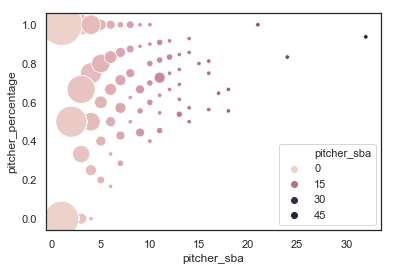

In [63]:
#pitchers
combos = list(zip(pitchers.pitcher_sba, pitchers.pitcher_percentage))
weight_counter = Counter(combos)
weights = [20* weight_counter[(pitchers.pitcher_sba[i], pitchers.pitcher_percentage[i])] for i, _ in enumerate(pitchers.pitcher_sba)]
sns.scatterplot("pitcher_sba", "pitcher_percentage", data = pitchers, hue = "pitcher_sba", s = weights)

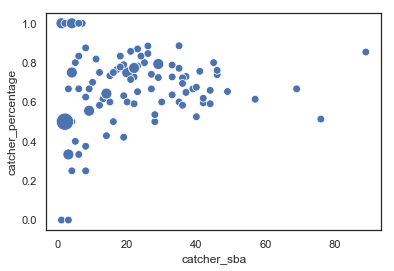

In [64]:
#catchers
combos = list(zip(catchers.catcher_sba, catchers.catcher_percentage))
weight_counter = Counter(combos)
weights = [60* weight_counter[(catchers.catcher_sba[i], catchers.catcher_percentage[i])] for i, _ in enumerate(catchers.catcher_sba)]
sns.scatterplot("catcher_sba", "catcher_percentage", data = catchers,  s = weights)

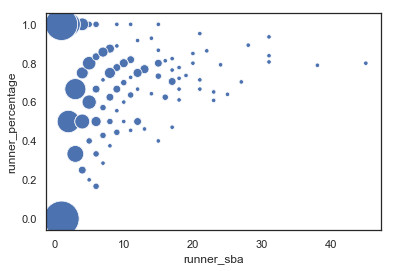

In [65]:
#runners

import random

combos = list(zip(runners.runner_sba, runners.runner_percentage))
weight_counter = Counter(combos)
weights = [20* weight_counter[(runners.runner_sba[i], runners.runner_percentage[i])] for i, _ in enumerate(runners.runner_sba)]
sns.scatterplot("runner_sba", "runner_percentage", data = runners,  s = weights)

In [62]:
#merge them back to df_sba

#for x in ['catcher_percentage', 'catcher_percentage_rtm', 'catcher_sba', 'pitcher_percentage', 'pitcher_percentage_rtm', 'pitcher_sba', 'runner_percentage', 'runner_percentage_rtm', 'runner_sba']:
#    df_sba = df_sba.drop(x, axis = 1)

df_sba = df_sba.merge(catchers[['pos2_fld_id', 'catcher_percentage', 'catcher_percentage_rtm', 'catcher_sba']], how = 'left', on = ['pos2_fld_id'])
df_sba = df_sba.merge(pitchers[['pitcher_id', 'pitcher_percentage', 'pitcher_percentage_rtm', 'pitcher_sba']], how = 'left', on = ['pitcher_id'])
df_sba = df_sba.merge(runners[['base_run1_id', 'runner_percentage', 'runner_percentage_rtm', 'runner_sba']], how = 'left', on = ['base_run1_id'])

In [66]:
# update features list
features_rtm =  ['catcher_percentage', 'catcher_percentage_rtm', 'catcher_sba', 'pitcher_percentage', 'pitcher_percentage_rtm', 'pitcher_sba' , 'runner_percentage', 'runner_percentage_rtm', 'runner_sba'] 
features_initial = features_initial + features_rtm

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

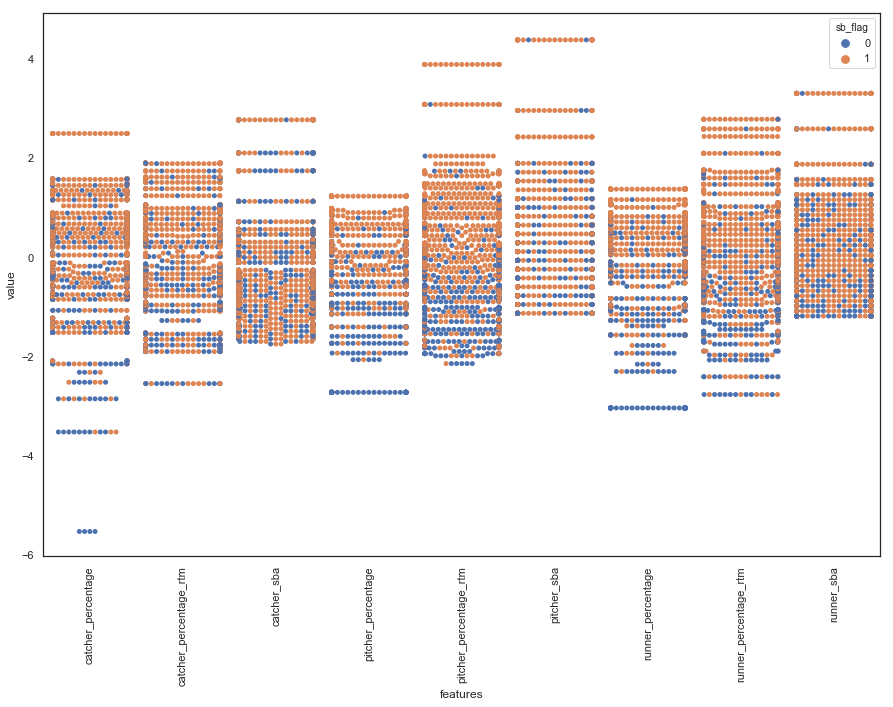

In [41]:
#Create swarmplot for new features

data = df_sba[features_rtm]
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([df_sba.sb_flag , data_n_2],axis=1)
data = pd.melt(data,id_vars="sb_flag",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(15, 10))
sns.swarmplot(x="features", y = "value", hue = "sb_flag", data =data)
plt.xticks(rotation=90)

# Final Feature Selection - Correlation
Correlation shows relationships between variables: first I look at correlations between sb_flag and other features then I check correlations between all features. I kept the non-regressed to the mean features for the charts just to check but will remove them. Based on the below chart pitcher_percentage_rtm is main criterion in stolen base flag. runner_percentage_rtm and catcher_percentage_rtm have also big influence.

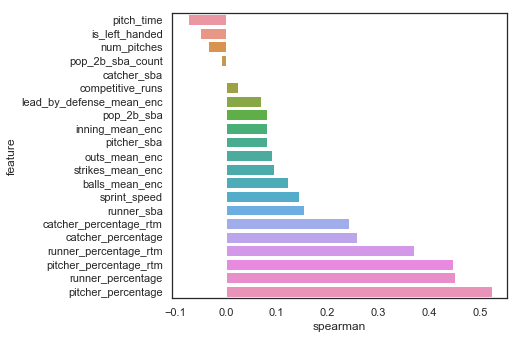

In [67]:
#correlation with sb_flag
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(df_sba['sb_flag'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features_to_plot = [f for f in df_sba[features_initial].columns if df_sba[features_initial].dtypes[f] != 'object']
features_to_plot.remove('cs_flag')
features_to_plot.remove('sb_flag')
spearman(df_sba, features_to_plot)

<Figure size 432x288 with 0 Axes>

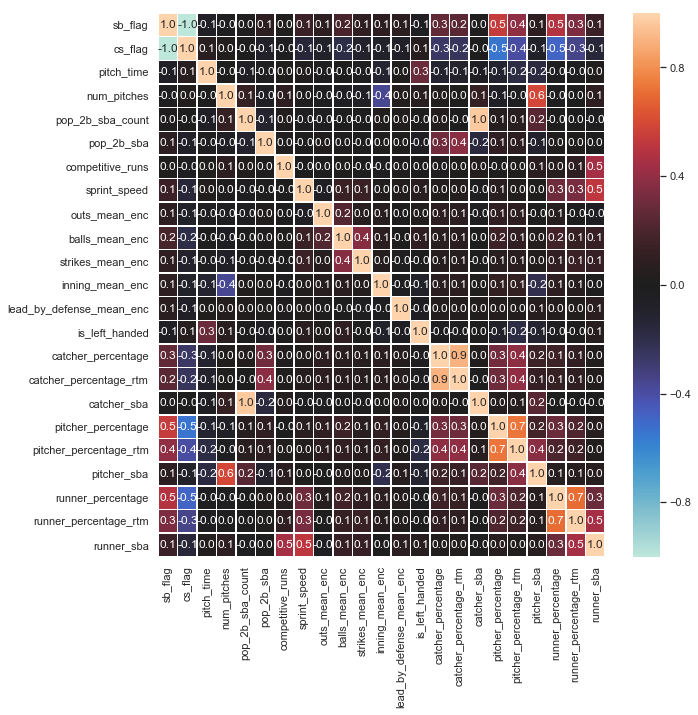

In [68]:
plt.figure(1)
plt.figure(figsize=(10,10))
corr = df_sba[features_initial].corr()
sns.heatmap(corr, annot= True, linewidth = .5, fmt = '.1f', center = 0)

There are many strong correlations between variables. Historical percentages and regressed to the mean percentages correlates to each other. Also catcher_sba and pop_2b_sba_count have 1 correlation. runner_sba correlates with competitive_runs and sprint_speed, pitcher_sba correlates to num_pitches.

I will remove the below features from final features list:
- cs_flag and sb_flag are target variables
- pop_2b_sba_count, num_pitches, competitive_runs (correlated to catcher_sba, pitcher_sba and runner_sba that I will keep)
- pitcher_percentage, runner_percentage, catcher_percentage: since there are many players with one or a few sba only I will use regressed to the mean features in the model not to overfit and get more generalized percentages for the players which are closer to their true talent.


In [69]:
#upate features list
for feature in ['cs_flag', 'sb_flag', 'pop_2b_sba_count', 'pitcher_percentage', 'runner_percentage', 'catcher_percentage',
                  'num_pitches','competitive_runs']:
    features_initial.remove(feature)

<Figure size 432x288 with 0 Axes>

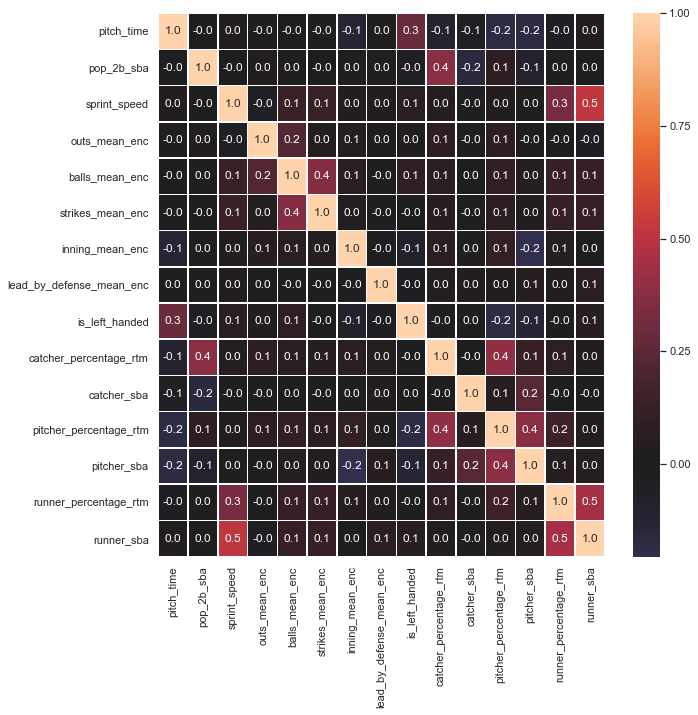

In [70]:
#final features correlation
plt.figure(1)
plt.figure(figsize=(10,10))
corr = df_sba[features_initial].corr()
sns.heatmap(corr, annot= True, linewidth = .5, fmt = '.1f', center = 0)

# Train-Test split
I keep 30% as test data (663), and use 70% as training data (1545).

In [71]:
# Establishing X and y
labels = df_sba['sb_flag']
features = df_sba[features_initial]

#normalization
features = (features - np.min(features)) / (np.max(features)- np.min(features)).values

#split into train and test data
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True)

print("features_train: " ,features_train.shape)
print("features_test: ", features_test.shape)
print("labels_train: ", labels_train.shape)
print("labels_test: ", labels_test.shape)

features_train:  (1545, 15)
features_test:  (663, 15)
labels_train:  (1545,)
labels_test:  (663,)


Text(0.5, 1.0, 'Test data')

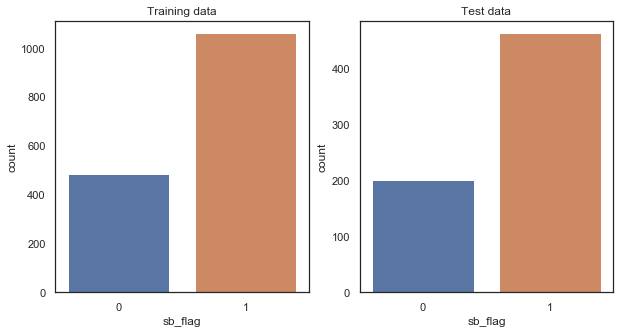

In [75]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))
sns.countplot(labels_train, label="Count", ax=ax[0]).set_title("Training data")
sns.countplot(labels_test, label="Count", ax = ax[1]).set_title("Test data")

# Trying different classifiers
First I try several classifiers on the training data with cross validation and see accuracy and f1 scores. Since the data is a unbalanced accuracy is not a good metric for evaluation. I could use precision, recall or f1-score. As a goal we could maximize the number of stolen bases (high recall) but in this case we can end up with too many outs, or minimize caught steals (high precision) but we could miss too many steal opportunities and lose some additional scores. To balance between the two cases I will use the F1-score for optimization.

In [77]:
def acc_and_f1(model):
    acc = np.round(np.mean(cross_val_score(model, features_train, labels_train, scoring = 'accuracy', cv = 10)), 5)
    f1 = np.round(np.mean(cross_val_score(model, features_train, labels_train, scoring = 'f1', cv = 10)), 5)
    return acc, f1

#Logistic regression
clf = LogisticRegression(random_state= 42, solver = 'liblinear')
LR = acc_and_f1(clf)

#Naive Bayes:
clfNB = GaussianNB()
NB = acc_and_f1(clfNB)

#K-nearest neighbours
clfKNN = KNeighborsClassifier (n_neighbors =5)
KNN = acc_and_f1(clfKNN)

#SVM
clfSVM = svm.SVC(gamma = 'auto')
SVM = acc_and_f1(clfSVM)

#RandomForest
clfRF = RandomForestClassifier(n_estimators = 20)
RF = acc_and_f1(clfRF)


#Decision Tree
clfDT = DecisionTreeClassifier()
DT = acc_and_f1(clfDT)


#summary table
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes',  
              'Decision Tree'],
    'Score': [SVM[0], KNN[0], LR[0], 
              RF[0], NB[0], DT[0]],
    'f1': [SVM[1], KNN[1], LR[1], 
              RF[1], NB[1], DT[1]]})


models.sort_values(by="f1" , ascending = False)

,Model,Score,f1
2,Logistic Regression,0.77018,0.84428
3,Random Forest,0.76888,0.84042
0,Support Vector Machines,0.74303,0.83430
4,Naive Bayes,0.73981,0.81253
5,Decision Tree,0.71066,0.78762
1,KNN,0.68993,0.78355


Logistic regression has highest f1-score although some other models have similar results. I will continue the analysis with logistic regression since the feature importance of LR is easy to interpret, it gives a probability as an output, and the model runs quicker which can be an important if it is used for real time decision making.

## Logistic Regression

Accurary: 0.799396681749623
Accurary on train: 0.7760517799352751
f1 score: 0.8665997993981946
logloss: 0.4612832029683017
              precision    recall  f1-score   support

           0       0.76      0.49      0.60       200
           1       0.81      0.93      0.87       463

   micro avg       0.80      0.80      0.80       663
   macro avg       0.78      0.71      0.73       663
weighted avg       0.79      0.80      0.78       663



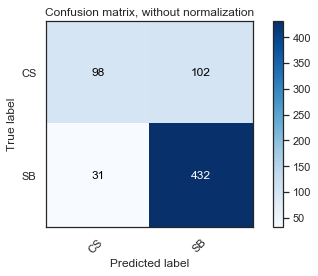

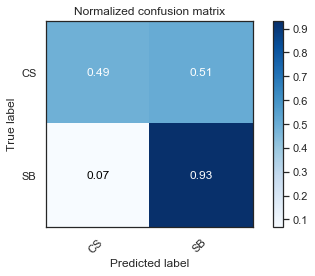

In [80]:
#Build logistic regression model and create predictions on test set

clf = LogisticRegression(random_state= 42, solver = 'liblinear') 
clf.fit(features_train, labels_train)

pred = clf.predict(features_test)
proba = clf.predict_proba(features_test)
proba = proba[:,1]


#confusion matrix and other metrics
cm = confusion_matrix(labels_test, pred)

print("Accurary:" , accuracy_score(pred, labels_test))
print("Accurary on train:" , accuracy_score(clf.predict(features_train), labels_train))
print( "f1 score:" , f1_score(labels_test,pred))
#calculate logloss
print("logloss:", log_loss(labels_test, proba))

#by elements
log_likelihood_elements = labels_test * np.log(proba) + (1- labels_test)*np.log(1-proba)
#-log_likelihood_elements.sum()/len(labels_test)

print(classification_report(labels_test,pred))

#plot confusion matrix
classes = df_sba.sb_flag #[CS, SB]
plot_confusion_matrix(labels_test, pred, classes,
                          normalize=False)
plot_confusion_matrix(labels_test, pred, classes,
                          normalize=True)

### GridSearch on C

best C:  {'C': 1.5000000000000002}
f1:  0.8471633538074018
Accurary: 0.7948717948717948
Accurary on train: 0.7792880258899676
f1 score: 0.8626262626262626
logloss: 0.4588765683562487
              precision    recall  f1-score   support

           0       0.74      0.50      0.60       200
           1       0.81      0.92      0.86       463

   micro avg       0.79      0.79      0.79       663
   macro avg       0.77      0.71      0.73       663
weighted avg       0.79      0.79      0.78       663



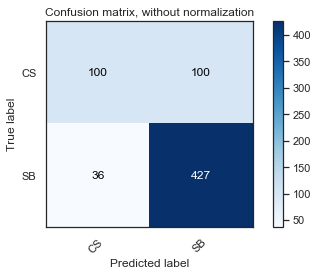

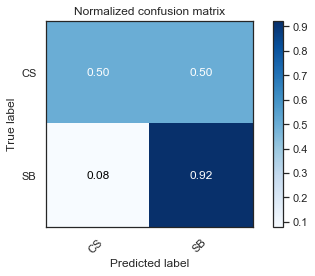

In [82]:
clf_C = LogisticRegression(random_state= 42, solver = 'liblinear') 
LRparam_grid = {'C': np.arange(0.1, 4, 0.1)}

LR_grid = GridSearchCV(clf_C, LRparam_grid, scoring = 'f1', cv = 10)
LR_grid.fit(features_train, labels_train)
print("best C: ", LR_grid.best_params_)
print("f1: " ,LR_grid.best_score_)

C_best = LR_grid.best_params_["C"]

#final model:
clf_best = LogisticRegression(C = C_best, random_state = 42,  solver = 'liblinear') 
clf_best.fit(features_train, labels_train)

pred = clf_best.predict(features_test)
proba = clf_best.predict_proba(features_test)
proba = proba[:,1]

#confusion matrix and other metrics
cm = confusion_matrix(labels_test, pred)


print("Accurary:" , accuracy_score(pred, labels_test))
print("Accurary on train:" , accuracy_score(clf_best.predict(features_train), labels_train))
print( "f1 score:" , f1_score(labels_test,pred))
#calculate logloss
print("logloss:", log_loss(labels_test, proba))

#by elements
log_likelihood_elements = labels_test * np.log(proba) + (1- labels_test)*np.log(1-proba)
#-log_likelihood_elements.sum()/len(labels_test)

print(classification_report(labels_test,pred))

classes = df_sba.sb_flag #[CS, SB]
plot_confusion_matrix(labels_test, pred, classes,
                          normalize=False)
plot_confusion_matrix(labels_test, pred, classes,
                          normalize=True)

### Visualization
Now that we have the predicted values for stolen base attempts both the training and test set, I perform a quick evaluation on the training set by plotting the probability estimated by the model with a double density plot.

We want the model to give high scores to steals (1) and low scores to caught steals (0). The ideal double density function should be separated for the two classes: caught steals on the left and steals on the right.

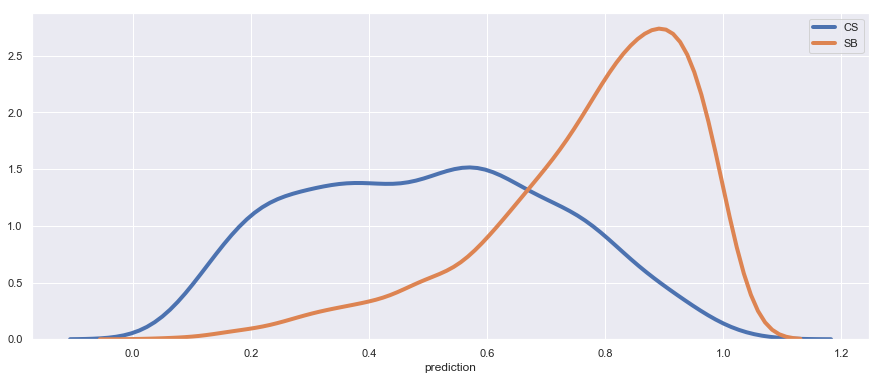

In [91]:
proba_train = clf_best.predict_proba(features_train)[:,1]
data_for_kde = pd.DataFrame(labels_train)
data_for_kde['prediction'] = proba_train

sns.set(rc={'figure.figsize' : (15,6)})
sns.distplot(data_for_kde[data_for_kde['sb_flag'] == 0]['prediction'], hist = False, kde = True, kde_kws = {'linewidth': 4}, label = "CS")

sns.distplot(data_for_kde[data_for_kde['sb_flag'] == 1]['prediction'], hist = False, kde = True, kde_kws = {'linewidth': 4},  label = "SB") 

In my model, both distributions are slightly skewed to the right. The probabilities for SB are predicted high but also many probabilities for CSs are high or higher than should be. 

Since the prediction of a logistic regression model is a probability, in order to use it as a classifier, we’ll have to choose a cutoff value, where scores above this value will be classified as positive (SB), those below as negative (CS).

I will visualize the confusion matrix of the test set with 0.5 cutoff value (probabilities larger than 0.5 will be categorized as SB and lower will be CS). The predicted scores are jittered along their label (along the 0-CS and 1-SB) to make it more clear. 

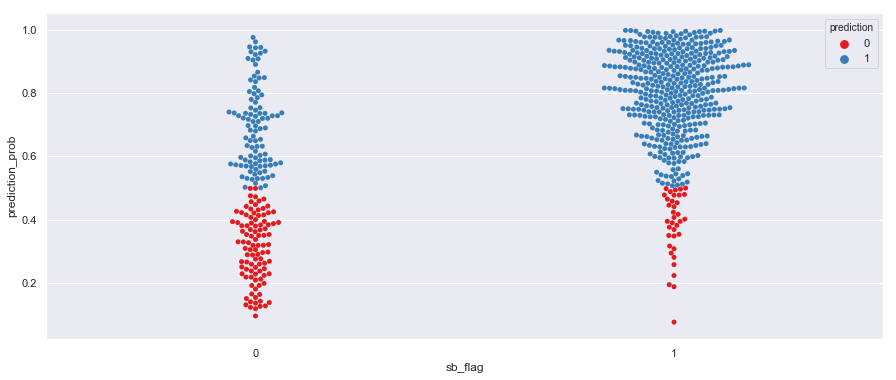

In [92]:
data_for_cm_plot = pd.DataFrame(labels_test)
data_for_cm_plot['prediction_prob'] = proba
data_for_cm_plot['prediction'] = pred

sns.swarmplot(x="sb_flag", y="prediction_prob",  data=data_for_cm_plot, hue="prediction" , palette = 'Set1') 

Based on the above the optimal cutoff is somewhere around 0.6.

## ROC Curve to choose optimal cutoff
I will visualize ROC curve. When we choose the cutoff value we make a balance between false positive and false negative rate. ROC curve visualize the tradeoff between the two measures.

AUC: 0.8289
Optimal threshold: 0.6078445129988663
cm: [[137  63]
 [ 69 394]]
Accurary: 0.8009049773755657
Accurary on train: 0.7792880258899676
f1 score: 0.8565217391304347
logloss: 0.4588765683562487
              precision    recall  f1-score   support

           0       0.67      0.69      0.67       200
           1       0.86      0.85      0.86       463

   micro avg       0.80      0.80      0.80       663
   macro avg       0.76      0.77      0.77       663
weighted avg       0.80      0.80      0.80       663



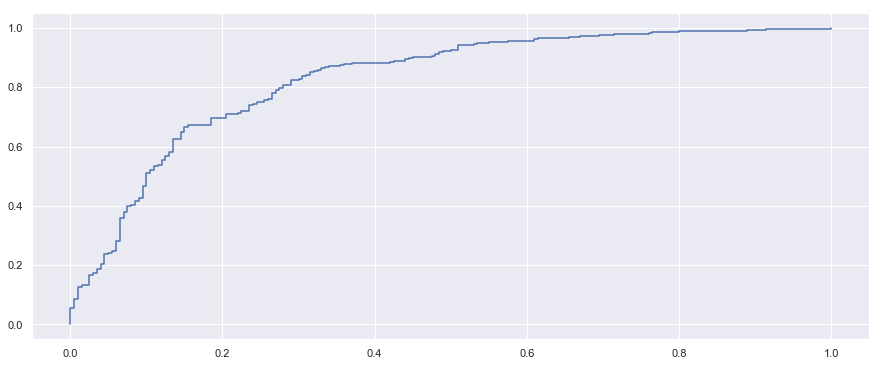

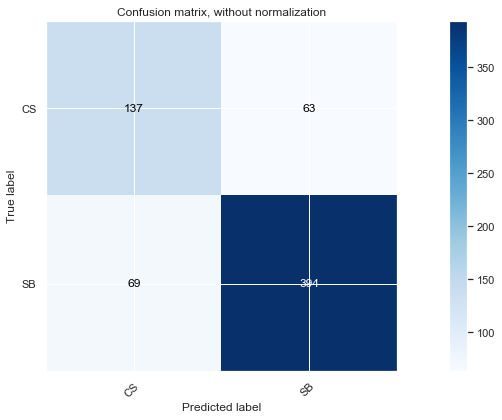

In [95]:
fpr, tpr, thr = roc_curve(labels_test, proba)
plt.plot(fpr, tpr)
print(f'AUC: {np.round(roc_auc_score(labels_test, proba), 4)}')

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thr[optimal_idx]
print ("Optimal threshold:" , optimal_threshold)

predicted = [1 if i > optimal_threshold else 0 for i in proba]
cm_2 = confusion_matrix(labels_test, predicted)
print ("cm:", cm_2)
print("Accurary:" , accuracy_score(labels_test, predicted))
print("Accurary on train:" , accuracy_score(labels_train, clf_best.predict(features_train)))
print( "f1 score:" , f1_score( labels_test, predicted))
print("logloss:", log_loss(labels_test, proba))

print(classification_report(labels_test,predicted))

plot_confusion_matrix(labels_test, predicted, classes,
                          normalize=False)

max f1-score: 0.8704253214638972
max accuracy: 0.808446455505279


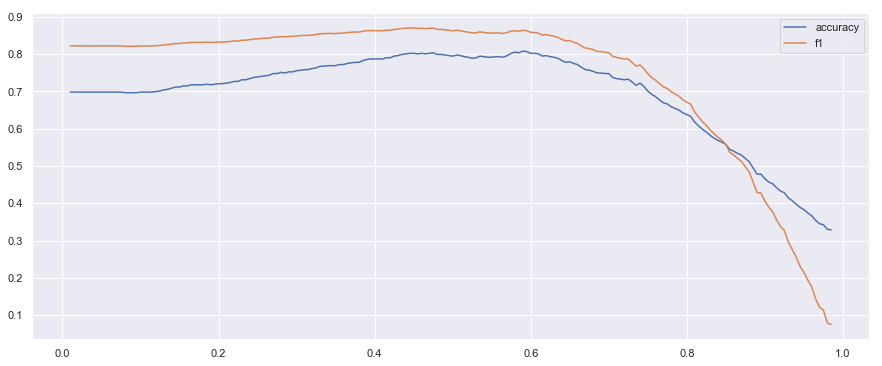

In [96]:
#optimal threshold by max accuracy, max f1
threshold= []
f1_score_th = []
acc_th = []
log_loss_th = []
for x in np.arange( 0.01, 0.99, 0.005):
    predicted = [1 if i > x else 0 for i in proba]
    #cm_2 = confusion_matrix(labels_test, predicted)
    
    threshold.append(x)
    f1_score_th.append(f1_score( labels_test, predicted ))#, average = 'weighted'))
    acc_th.append(accuracy_score(labels_test, predicted))
    
    
print("max f1-score:", max(f1_score_th))
    
print("max accuracy:", max(acc_th))

plt.plot(threshold, acc_th, label = "accuracy")
plt.legend()
plt.plot(threshold, f1_score_th, label = "f1")
plt.legend()

## Feature importance
I check feature importance using different techniques. The most important features are pitcher_percentage_rtm and runner_percentage_rtm which are the historical stolen base success rates for pitchers and runners. All feature selection techniques give similar results. Based on their output model could be refitted using the selected features only.

In [97]:
coeff_df = pd.DataFrame(features_train.columns) 
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(clf_best.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
11,pitcher_percentage_rtm,5.626840
13,runner_percentage_rtm,3.602759
9,catcher_percentage_rtm,0.861241
2,sprint_speed,0.826811
7,lead_by_defense_mean_enc,0.771203
12,pitcher_sba,0.723741
4,balls_mean_enc,0.668777
14,runner_sba,0.207557
3,outs_mean_enc,0.174890
8,is_left_handed,0.052752


#### Feature selection using RFECV
Optimal number of features are 7: 'sprint_speed', 'balls_mean_enc', 'lead_by_defense_mean_enc',
       'catcher_percentage_rtm', 'pitcher_percentage_rtm', 'pitcher_sba', 'runner_percentage_rtm'

In [98]:
rfecv = RFECV(estimator=clf_best, step=1, cv=5,scoring='f1')   #5-fold cross-validation
rfecv = rfecv.fit(features_train, labels_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', features_train.columns[rfecv.support_])

Optimal number of features : 7
Best features : Index(['sprint_speed', 'balls_mean_enc', 'lead_by_defense_mean_enc',
       'catcher_percentage_rtm', 'pitcher_percentage_rtm', 'pitcher_sba',
       'runner_percentage_rtm'],
      dtype='object')


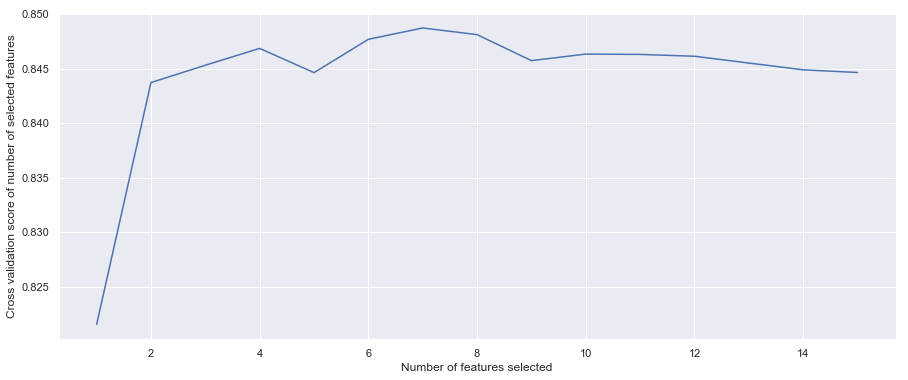

In [99]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#### Select From Model

In [101]:
smf = SelectFromModel(clf_best, threshold = -np.inf, max_features = 7)
smf.fit(features_train, labels_train)
feature_idx = smf.get_support()
feature_name = features.columns[feature_idx]
feature_name

Index(['sprint_speed', 'balls_mean_enc', 'lead_by_defense_mean_enc',
       'catcher_percentage_rtm', 'pitcher_percentage_rtm', 'pitcher_sba',
       'runner_percentage_rtm'],
      dtype='object')

#### RFE 

In [102]:
predictors = features_train
selector = RFE(clf_best, n_features_to_select = 1)
selector = selector.fit(predictors, labels_train)

order = selector.ranking_

feature_ranks = []
k= 0
for i in order:
    feature_ranks.append(f"{i}. {features.columns[k]}")
    k=k+1
feature_ranks

['12. pitch_time',
 '11. pop_2b_sba',
 '3. sprint_speed',
 '10. outs_mean_enc',
 '6. balls_mean_enc',
 '14. strikes_mean_enc',
 '15. inning_mean_enc',
 '5. lead_by_defense_mean_enc',
 '13. is_left_handed',
 '4. catcher_percentage_rtm',
 '8. catcher_sba',
 '1. pitcher_percentage_rtm',
 '7. pitcher_sba',
 '2. runner_percentage_rtm',
 '9. runner_sba']

#### Kbest

In [103]:
# find best scored 7 features
select_feature = SelectKBest(chi2, k=7).fit(features_train, labels_train)

print('Score list:', select_feature.scores_)
print('Feature list:', features_train.columns)

Score list: [2.19141986e-01 4.04096202e-01 1.41921063e+00 3.82613413e+00
 5.09836646e+00 7.12240419e+00 1.00726741e+00 6.72584657e-01
 1.77869023e+00 7.14263139e+00 1.06938655e-02 1.99043171e+01
 2.89862213e+00 1.18450797e+01 8.02237496e+00]
Feature list: Index(['pitch_time', 'pop_2b_sba', 'sprint_speed', 'outs_mean_enc',
       'balls_mean_enc', 'strikes_mean_enc', 'inning_mean_enc',
       'lead_by_defense_mean_enc', 'is_left_handed', 'catcher_percentage_rtm',
       'catcher_sba', 'pitcher_percentage_rtm', 'pitcher_sba',
       'runner_percentage_rtm', 'runner_sba'],
      dtype='object')


### Learning curve

In [104]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, 
                        n_jobs = 1,  train_sizes = np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes, scoring = "f1") #neg_log_loss
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

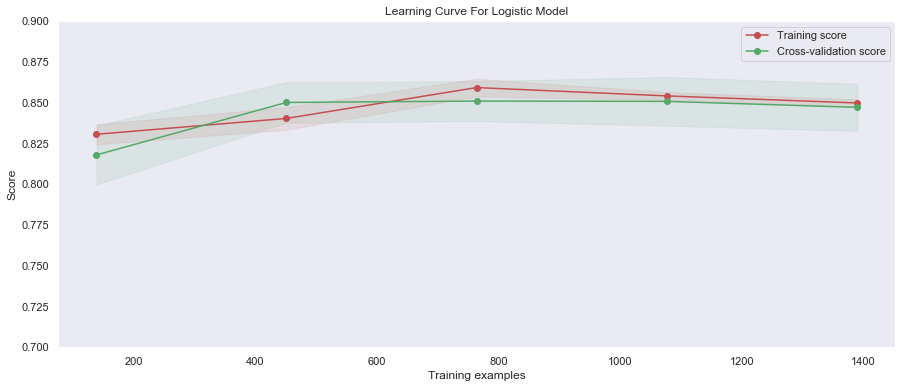

In [105]:
#Learning curve 
plot_learning_curve(clf_best, 'Learning Curve For Logistic Model', features_train, labels_train, (0.7, 0.9), 10)
plt.savefig('7')
plt.show()

Based on the learning curve there might be little to learn. In this case even a small sample size can allow the model to find all detectable patterns, resulting in an early "high" score. If not all patterns can be detected, no perfect score can be achieved. Adding more features or polynomials could possibly increase scores. 

# Save output to csv

In [107]:
#SAVE

final_data = features_test
final_data['label_real'] = labels_test
final_data['label_predicted'] = pred
final_data['log_likelihood_elements'] = -log_likelihood_elements
final_data['probablity'] = proba

# save data to csv
file_name = 'prediction.csv'
final_data.to_csv(file_name)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

# Next Steps

#### Adding features
To improve the model we would need other features to be added which have more predictive power in deciding whether it is a stolen base or a caught steal. There are some information which would be very useful for the baserunner to know but not available at the time when the decision has to be made. These are for example the pitch type, location or pitch speed. We could add features to the model which have similar information but available beforehand: the pitcher's pitch type distribution stats could be a proxy for the pitch type and a closer velocity estimate than what we have now; the hitter's plate discipline could help to guess the location. First pitch strike percentage can be useful too as seen earlier. Some more runner stats like jump or lead or hitter's wOBA could probably improve the model as well (the pitcher and catcher are more focused on getting the hitter out if a better hitter is up increasing the chance for successful stolen base for the runner).

#### Outliers
Removing outliers from the data can also improve model efficiency. If pickoff event are included in the data those should be also removed. Use regression to the mean techniques where needed due to small data.